In [1]:
from time import time
import numpy as np
from matplotlib import pyplot as plt

# Qiskit
from qiskit import IBMQ

# Local modules
from utilities import startup, check_provider
from graphstate import GraphState, calc_negativities, calc_n_mean, get_negativity_info, get_largest_connected, get_mean_cnot, filter_edges
from visualization import plot_negativities_multi, plot_cxerr_corr, plot_negativities127, plot_nmap127

provider = startup()

Account enabled
Provider: ibm-q-melbourne


## Negativity Decays

#### Free Decays

In [2]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)

In [3]:
shots = 2048
dd = None

In [4]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, qrem=True, execute_only=True)

In [ ]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=3, dd=dd, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=6, dd=dd, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=9, dd=dd, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=12, dd=dd, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=15, dd=dd, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=18, dd=dd, qrem=True, execute_only=True)
job8 = graphstate.run_qst(reps=1, shots=shots, delay=21, dd=dd, qrem=True, execute_only=True)
job9 = graphstate.run_qst(reps=1, shots=shots, delay=24, dd=dd, qrem=True, execute_only=True)
job10 = graphstate.run_qst(reps=1, shots=shots, delay=27, dd=dd, qrem=True, execute_only=True)
job11 = graphstate.run_qst(reps=1, shots=shots, delay=30, dd=dd, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())
print("Job 3 ID:", job3.job_id())
print("Job 4 ID:", job4.job_id())
print("Job 5 ID:", job5.job_id())
print("Job 6 ID:", job6.job_id())
print("Job 7 ID:", job7.job_id())
print("Job 8 ID:", job8.job_id())
print("Job 9 ID:", job9.job_id())
print("Job 10 ID:", job10.job_id())
print("Job 11 ID:", job11.job_id())

In [ ]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)

job1 = backend.retrieve_job('')
job2 = backend.retrieve_job('')
job3 = backend.retrieve_job('')
job4 = backend.retrieve_job('')
job5 = backend.retrieve_job('')
job6 = backend.retrieve_job('')
job7 = backend.retrieve_job('')
job8 = backend.retrieve_job('')
job9 = backend.retrieve_job('')
job10 = backend.retrieve_job('')
job11 = backend.retrieve_job('')

In [4]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 97.96 s


In [5]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
n_list8 = calc_negativities(rho_dict8, mode='mean')
nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
n_list9 = calc_negativities(rho_dict9, mode='mean')
nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')
n_list10 = calc_negativities(rho_dict10, mode='mean')
nmit_list10 = calc_negativities(rho_dict_mit10, mode='mean')
n_list11 = calc_negativities(rho_dict11, mode='mean')
nmit_list11 = calc_negativities(rho_dict_mit11, mode='mean')

#info_dict = get_negativity_info(n_list1, nmit_list1)
#m, s = get_mean_cnot(graphstate, job1.properties())

#info_dict

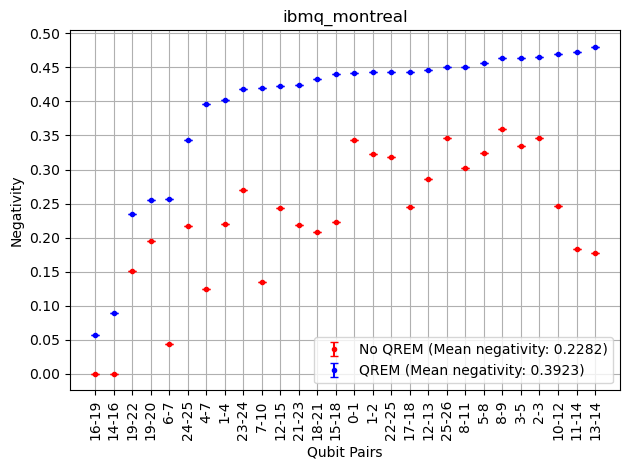

In [5]:
fig1 = plot_negativities_multi(backend, n_list1, nmit_list1)

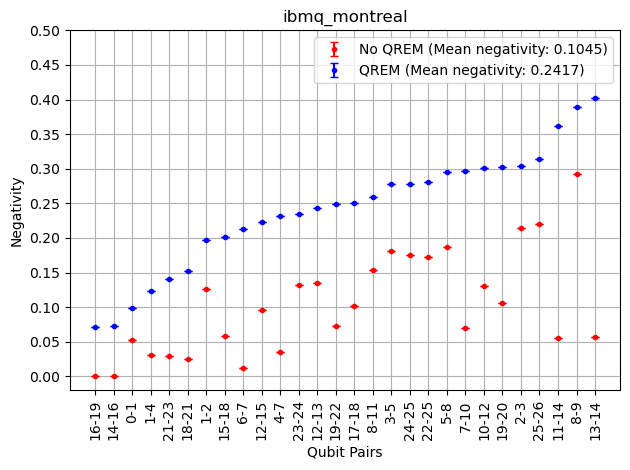

In [6]:
fig2 = plot_negativities_multi(backend, n_list2, nmit_list2)

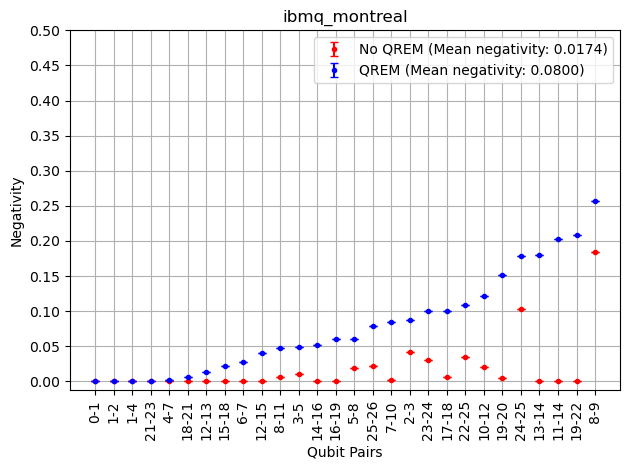

In [7]:
fig3 = plot_negativities_multi(backend, n_list3, nmit_list3)

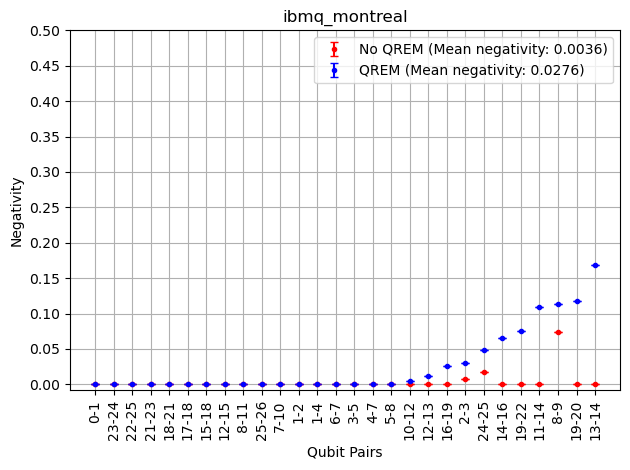

In [8]:
fig4 = plot_negativities_multi(backend, n_list4, nmit_list4)

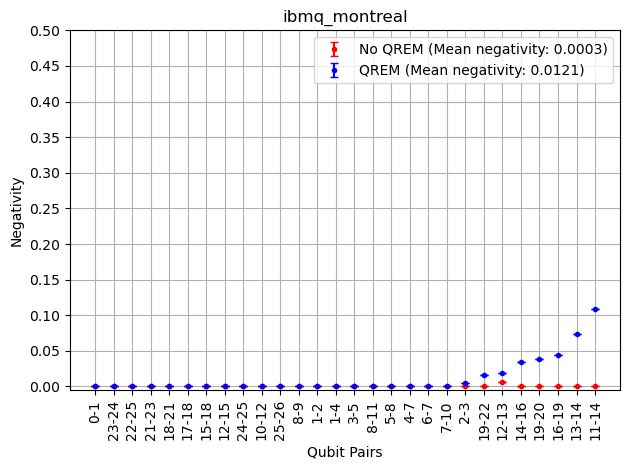

In [9]:
fig5 = plot_negativities_multi(backend, n_list5, nmit_list5)

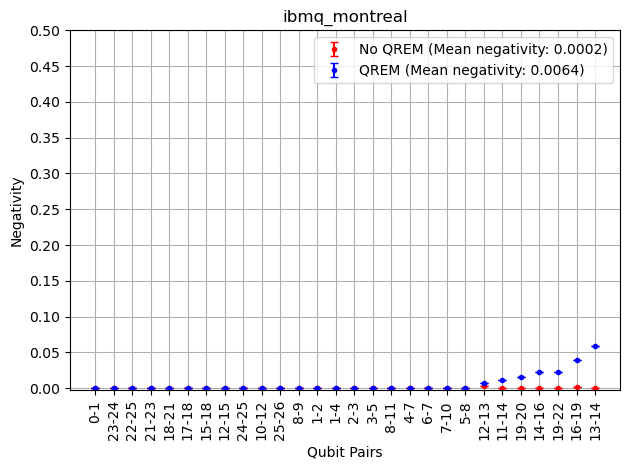

In [10]:
fig6 = plot_negativities_multi(backend, n_list6, nmit_list6)

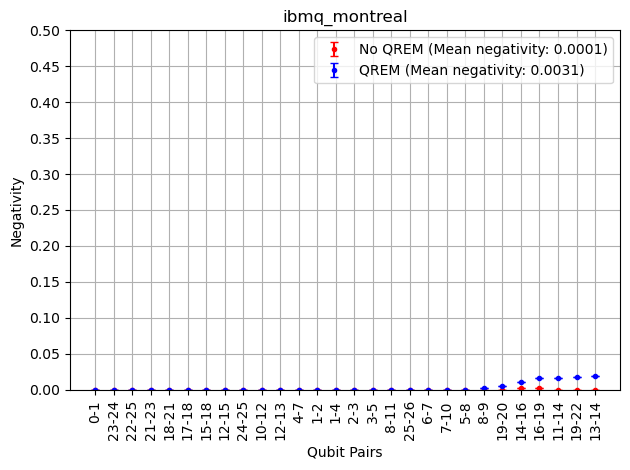

In [11]:
fig7 = plot_negativities_multi(backend, n_list7, nmit_list7)

#### Hahn Echo

In [3]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)

In [4]:
shots = 2048
dd = 'hahn'

In [13]:
job1 = graphstate.run_qst(reps=1, shots=shots, delay=None, dd=dd, qrem=True, execute_only=True)
job2 = graphstate.run_qst(reps=1, shots=shots, delay=3, dd=dd, qrem=True, execute_only=True)
job3 = graphstate.run_qst(reps=1, shots=shots, delay=6, dd=dd, qrem=True, execute_only=True)
job4 = graphstate.run_qst(reps=1, shots=shots, delay=9, dd=dd, qrem=True, execute_only=True)
job5 = graphstate.run_qst(reps=1, shots=shots, delay=12, dd=dd, qrem=True, execute_only=True)
job6 = graphstate.run_qst(reps=1, shots=shots, delay=15, dd=dd, qrem=True, execute_only=True)
job7 = graphstate.run_qst(reps=1, shots=shots, delay=18, dd=dd, qrem=True, execute_only=True)
job8 = graphstate.run_qst(reps=1, shots=shots, delay=21, dd=dd, qrem=True, execute_only=True)
job9 = graphstate.run_qst(reps=1, shots=shots, delay=24, dd=dd, qrem=True, execute_only=True)
job10 = graphstate.run_qst(reps=1, shots=shots, delay=27, dd=dd, qrem=True, execute_only=True)
job11 = graphstate.run_qst(reps=1, shots=shots, delay=30, dd=dd, qrem=True, execute_only=True)

print("Device:", backend.name(), f'({len(backend.properties().qubits)} qubits)')
print("Job 1 ID:", job1.job_id())
print("Job 2 ID:", job2.job_id())
print("Job 3 ID:", job3.job_id())
print("Job 4 ID:", job4.job_id())
print("Job 5 ID:", job5.job_id())
print("Job 6 ID:", job6.job_id())
print("Job 7 ID:", job7.job_id())
print("Job 8 ID:", job8.job_id())
print("Job 9 ID:", job9.job_id())
print("Job 10 ID:", job10.job_id())
print("Job 11 ID:", job11.job_id())

Device: ibm_hanoi (27 qubits)
Job 1 ID: 64223d94c0534827f5d3da19
Job 2 ID: 64223d9ec0092c0ce29d21c6
Job 3 ID: 64223da6c0534816add3da1a
Job 4 ID: 64223db0e10f2b74ab5d64d8
Job 5 ID: 64223db85c50b31b0b7978e3
Job 6 ID: 64223dbf6f22154f681e9240
Job 7 ID: 64223dc66f22155c501e9241
Job 8 ID: 64223dcd2a1c7a05342f64a8
Job 9 ID: 64223dd4bb079d207361b9e2
Job 10 ID: 64223ddcc05348848bd3da1c
Job 11 ID: 64223de3c053485b2ad3da1d


In [3]:
backend = provider.get_backend('ibm_hanoi')
graphstate = GraphState(backend)

job1 = backend.retrieve_job('64223d94c0534827f5d3da19')
job2 = backend.retrieve_job('64223d9ec0092c0ce29d21c6')
job3 = backend.retrieve_job('64223da6c0534816add3da1a')
job4 = backend.retrieve_job('64223db0e10f2b74ab5d64d8')
job5 = backend.retrieve_job('64223db85c50b31b0b7978e3')
job6 = backend.retrieve_job('64223dbf6f22154f681e9240')
job7 = backend.retrieve_job('64223dc66f22155c501e9241')
job8 = backend.retrieve_job('64223dcd2a1c7a05342f64a8')
job9 = backend.retrieve_job('64223dd4bb079d207361b9e2')
job10 = backend.retrieve_job('64223ddcc05348848bd3da1c')
job11 = backend.retrieve_job('64223de3c053485b2ad3da1d')

In [4]:
time0 = time()
rho_dict_mit1, rho_dict1 = graphstate.qst_from_result(job1.result(), 'all')
rho_dict_mit2, rho_dict2 = graphstate.qst_from_result(job2.result(), 'all')
rho_dict_mit3, rho_dict3 = graphstate.qst_from_result(job3.result(), 'all')
rho_dict_mit4, rho_dict4 = graphstate.qst_from_result(job4.result(), 'all')
rho_dict_mit5, rho_dict5 = graphstate.qst_from_result(job5.result(), 'all')
rho_dict_mit6, rho_dict6 = graphstate.qst_from_result(job6.result(), 'all')
rho_dict_mit7, rho_dict7 = graphstate.qst_from_result(job7.result(), 'all')
rho_dict_mit8, rho_dict8 = graphstate.qst_from_result(job8.result(), 'all')
rho_dict_mit9, rho_dict9 = graphstate.qst_from_result(job9.result(), 'all')
rho_dict_mit10, rho_dict10 = graphstate.qst_from_result(job10.result(), 'all')
rho_dict_mit11, rho_dict11 = graphstate.qst_from_result(job11.result(), 'all')
time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

Time elapsed: 97.96 s


In [5]:
n_list1 = calc_negativities(rho_dict1, mode='mean')
nmit_list1 = calc_negativities(rho_dict_mit1, mode='mean')
n_list2 = calc_negativities(rho_dict2, mode='mean')
nmit_list2 = calc_negativities(rho_dict_mit2, mode='mean')
n_list3 = calc_negativities(rho_dict3, mode='mean')
nmit_list3 = calc_negativities(rho_dict_mit3, mode='mean')
n_list4 = calc_negativities(rho_dict4, mode='mean')
nmit_list4 = calc_negativities(rho_dict_mit4, mode='mean')
n_list5 = calc_negativities(rho_dict5, mode='mean')
nmit_list5 = calc_negativities(rho_dict_mit5, mode='mean')
n_list6 = calc_negativities(rho_dict6, mode='mean')
nmit_list6 = calc_negativities(rho_dict_mit6, mode='mean')
n_list7 = calc_negativities(rho_dict7, mode='mean')
nmit_list7 = calc_negativities(rho_dict_mit7, mode='mean')
n_list8 = calc_negativities(rho_dict8, mode='mean')
nmit_list8 = calc_negativities(rho_dict_mit8, mode='mean')
n_list9 = calc_negativities(rho_dict9, mode='mean')
nmit_list9 = calc_negativities(rho_dict_mit9, mode='mean')
n_list10 = calc_negativities(rho_dict10, mode='mean')
nmit_list10 = calc_negativities(rho_dict_mit10, mode='mean')
n_list11 = calc_negativities(rho_dict11, mode='mean')
nmit_list11 = calc_negativities(rho_dict_mit11, mode='mean')

#info_dict = get_negativity_info(n_list1, nmit_list1)
#m, s = get_mean_cnot(graphstate, job1.properties())

#info_dict

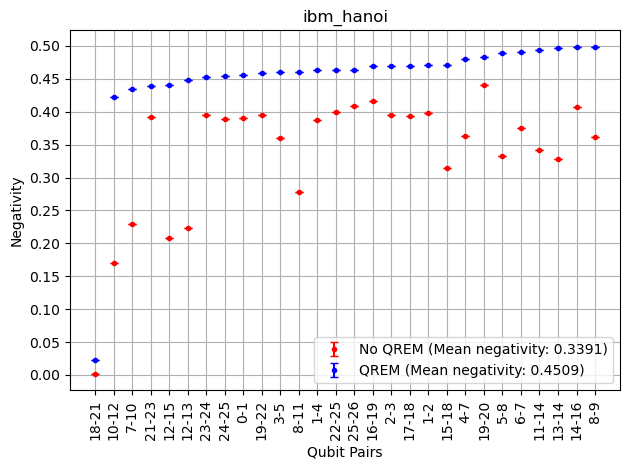

In [44]:
fig1, idx = plot_negativities_multi(backend, n_list1, nmit_list1, return_idx=True)

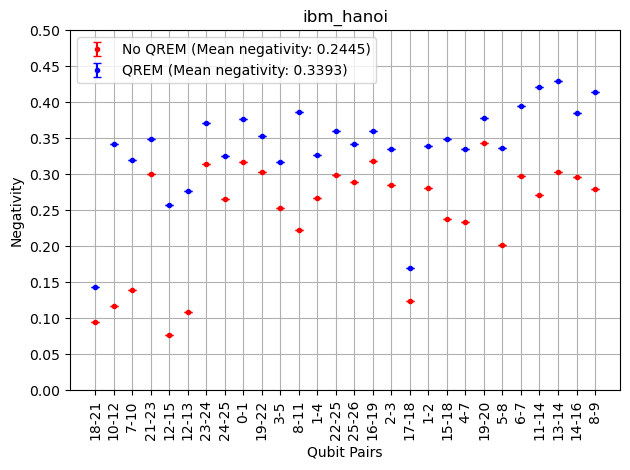

In [45]:
fig2 = plot_negativities_multi(backend, n_list2, nmit_list2, idx=idx)

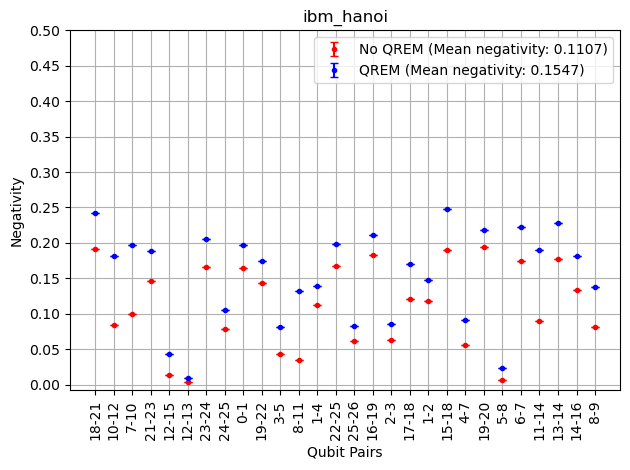

In [46]:
fig3 = plot_negativities_multi(backend, n_list3, nmit_list3, idx=idx)

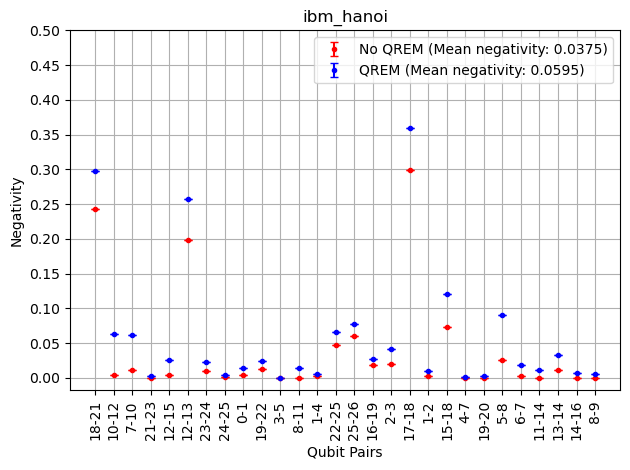

In [47]:
fig4 = plot_negativities_multi(backend, n_list4, nmit_list4, idx=idx)

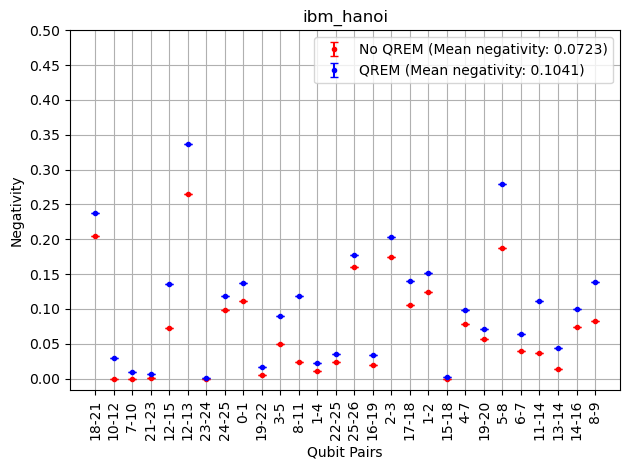

In [48]:
fig5 = plot_negativities_multi(backend, n_list5, nmit_list5, idx=idx)

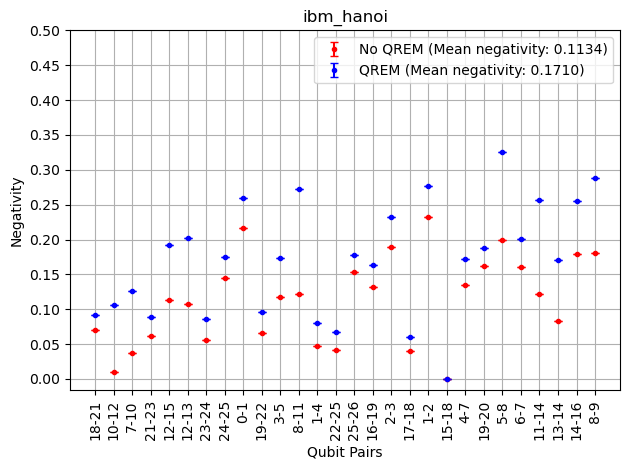

In [49]:
fig6 = plot_negativities_multi(backend, n_list6, nmit_list6, idx=idx)

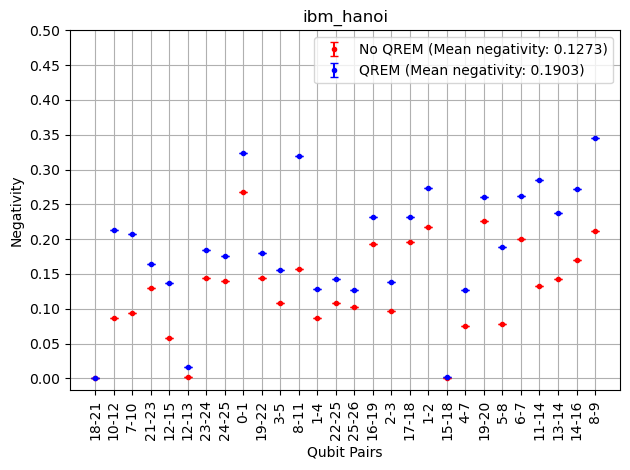

In [50]:
fig7 = plot_negativities_multi(backend, n_list7, nmit_list7, idx=idx)

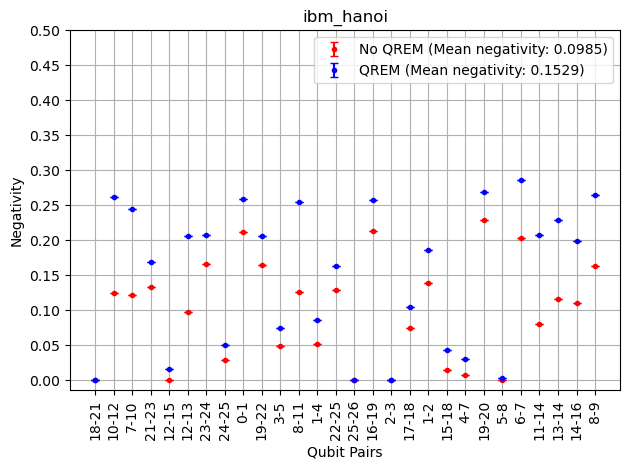

In [51]:
fig8 = plot_negativities_multi(backend, n_list8, nmit_list8, idx=idx)

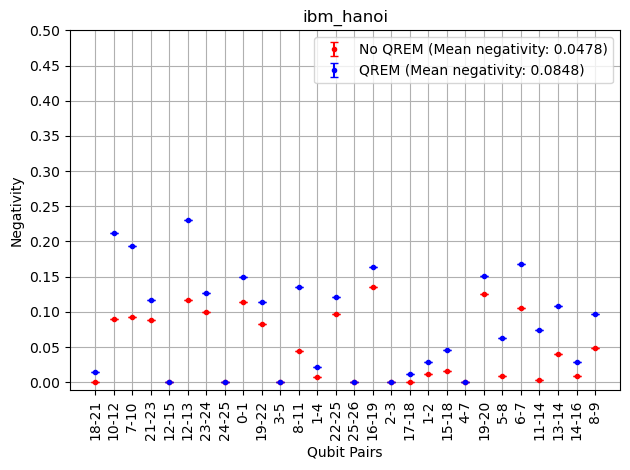

In [52]:
fig9 = plot_negativities_multi(backend, n_list9, nmit_list9, idx=idx)

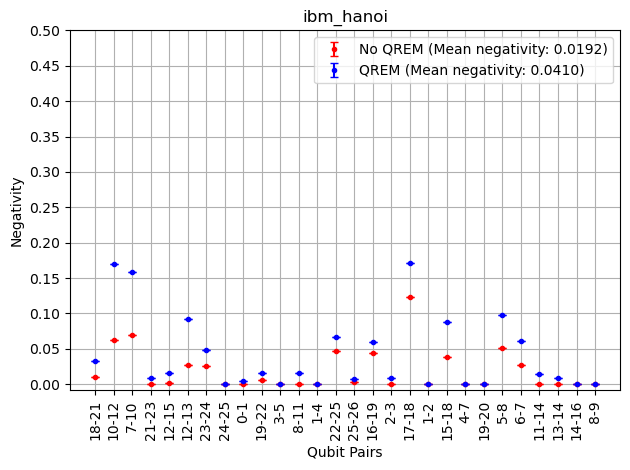

In [53]:
fig10 = plot_negativities_multi(backend, n_list10, nmit_list10, idx=idx)

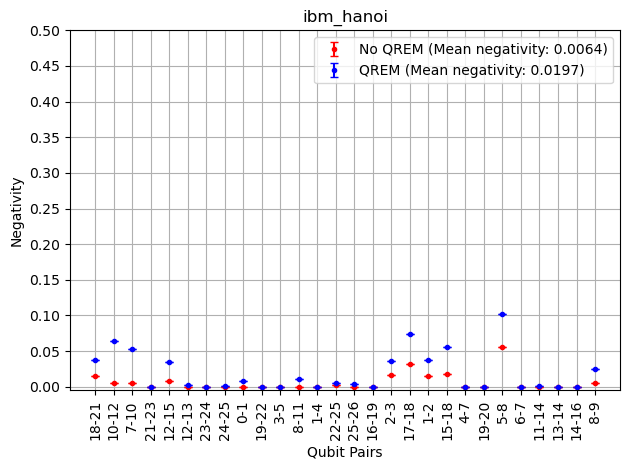

In [54]:
fig11 = plot_negativities_multi(backend, n_list11, nmit_list11, idx=idx)

#### Plotting Functions

In [145]:
def collate_n_lists(n_lists):
    return {key: [n_list[key] for n_list in n_lists] for key in n_lists[0]}

def calc_nmean_decay(n_decays):
    n_array = np.zeros((len(n_decays[(0, 1)]), len(n_decays)))
    n_array = np.zeros((len(n_decays[(0, 1)]), len(n_decays)))
    for i, value in enumerate(n_decays.values()):
        n_array[:,i] = np.array(value)
    return np.mean(n_array, axis=1), np.std(n_array, axis=1)

def plot_ndecays(n_lists, edges, step, label=None, fig=None):
    figsize = (7.5, 5)
    if fig is None:
        fig, ax = plt.subplots()
    else:
        ax = plt.gca()
    n_decays = collate_n_lists(n_lists)
    
    try:
        X = np.arange(0, step*len(n_decays[(0, 1)]), step)
        if edges == 'all':
            for edge, Y in n_decays.items():
                ax.plot(X, Y, label=label)
        elif edges == 'mean':
            Y, Ystd = calc_nmean_decay(n_decays)
            ax.errorbar(X, Y, yerr=Ystd, label=label, marker='o', markersize=4, ls='--', elinewidth=1, capsize=3)
            ax.set_title('Mean device negativity decay')
        else:
            for edge in edges:
                Y = n_decays[edge]
                ax.plot(X, Y, label=label, marker='o')
    except:
        Y = n_decays[edges]
        X = np.arange(0, step*len(X), step)
        ax.plot(X, Y, label=label, marker='o')
        
    ax.grid(True)
    ax.set_xlabel('Delay $\it{t}$ (μs)')
    ax.set_ylabel('Negativity')
    ax.set_yticks(np.arange(0, 0.55, 0.05))
    
    if label is not None:
        ax.legend()
        
    return fig

In [146]:
n_lists = [n_list1, n_list2, n_list3, n_list4, n_list5, n_list6, n_list7, n_list8, n_list9, n_list10, n_list11]
nmit_lists = [nmit_list1, nmit_list2, nmit_list3, nmit_list4, nmit_list5, nmit_list6, nmit_list7, nmit_list8, nmit_list9, nmit_list10, nmit_list11]

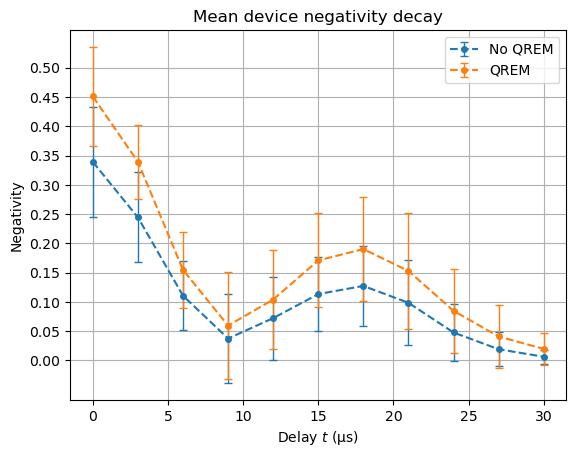

In [147]:
fig = plot_ndecays(n_lists, edges='mean', step=3, label='No QREM')
fig = plot_ndecays(nmit_lists, edges='mean', step=3, label='QREM', fig=fig)